In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [4]:
from feature_extraction_helper import extract_extrema, moving_average, smooth_trace, find_extrema_and_peaks
from feature_extraction_helper import extract_peaks_valleys_arrays,reshape_feature_array

## Load data

In [5]:
master_path = Path(Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata') / 'Raw_Data')
out_path = Path(master_path/'Processed_Data')
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0')]

In [6]:
fish= 0
fish_path = fish_paths[fish]
fish_id =  fish_paths[fish].name
exp_name = 'testfish'
exp_name, fish_id

('testfish', '240423_f0')

In [7]:
save_data_path = out_path

## Load traces and make tensor in shape (trials, tails, left fin, right fin)

In [8]:
bout_data = fl.load(out_path/'{}_bout_data.h5'.format(fish_id))
bout_data.keys()

dict_keys(['body_angles', 'body_angles_delta', 'bout_times', 'cluster', 'dlc_filter', 'edge_filter', 'eye_angles', 'eye_rotation', 'eye_vergence', 'fin_angles', 'laterality', 'mb_proba', 'motor', 'tail_vectors', 'tailsums'])

In [9]:
data = fl.load(out_path / '{}_tensor.h5'.format(fish_id))
indices = fl.load(out_path / '{}_indices.h5'.format(fish_id))
data.shape


(460, 3, 50)

In [10]:
## specify 0 for tail, 1 for l fin and 2 for right fin
## because we dont want to confuse peaks and vallyes later -> left invert l fin

data_tail = data[:,0,:]
data_l_fin = data[:,1,:]*-1
data_r_fin = data[:,2,:]


In [11]:
### flip tail to all be on the same side?

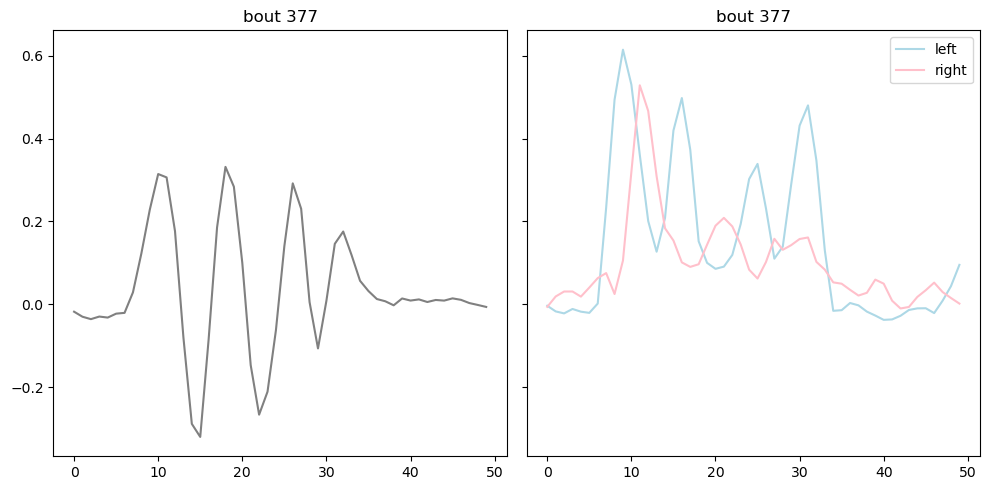

In [12]:
bout = np.random.randint(0,data_tail.shape[0])

fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].plot(data_tail[bout,:], c='gray', label='tail')
axes[0].set_title('bout {}'.format(bout))

axes[1].plot(data_l_fin[bout,:], c='lightblue', label='left')
axes[1].plot(data_r_fin[bout,:], c='pink', label='right')
axes[1].set_title('bout {}'.format(bout))

plt.legend()
plt.tight_layout()

# Code to extract peaks and valleys

In [13]:
datas = [data_tail, data_l_fin, data_r_fin]
feat_array_lists = []

for data_ in datas:
    # data = np.apply_along_axis(smooth_trace, 1, data_)
    peaks_a, peaks_i, valleys_a, valleys_i = find_extrema_and_peaks(data_, thr=.2)

    peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array = extract_peaks_valleys_arrays(data_, peaks_a, peaks_i, valleys_a, valleys_i, max_n=9)
    # concatenate feature array
    feature_vector_array = np.concatenate([peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array], axis=1)
    feat_array_lists.append(feature_vector_array)
    
fl.save(save_data_path/ '{}_t_feature_vector_array.h5'.format(fish_id), feat_array_lists[0])
fl.save(save_data_path/ '{}_l_feature_vector_array.h5'.format(fish_id), feat_array_lists[1])
fl.save(save_data_path/ '{}_r_feature_vector_array.h5'.format(fish_id), feat_array_lists[2])

In [16]:
t_reshaped_array, t_peaks_a_array, t_peaks_i_array, t_valleys_a_array, t_valleys_i_array = reshape_feature_array(feat_array_lists[0])
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(feat_array_lists[1])
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(feat_array_lists[2])

Reshaped array shape: (460, 4, 9)
Reshaped array shape: (460, 4, 9)
Reshaped array shape: (460, 4, 9)


## Plot random ROI to check

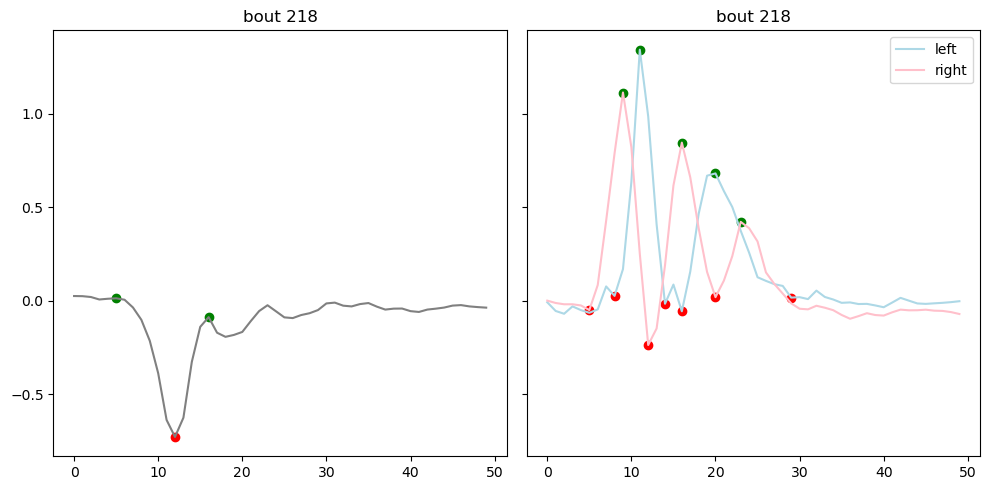

In [17]:
bout = np.random.randint(0,data_tail.shape[0])

fig, axes = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.ravel()
axes[0].plot(data_tail[bout,:], c='gray', label='tail')
axes[0].scatter(t_peaks_i_array[bout], t_peaks_a_array[bout], c='green')
axes[0].scatter(t_valleys_i_array[bout], t_valleys_a_array[bout], c='red')
axes[0].set_title('bout {}'.format(bout))

axes[1].plot(data_l_fin[bout,:], c='lightblue', label='left')
axes[1].scatter(l_peaks_i_array[bout], l_peaks_a_array[bout], c='green')
axes[1].scatter(l_valleys_i_array[bout], l_valleys_a_array[bout], c='red')

axes[1].plot(data_r_fin[bout,:], c='pink', label='right')
axes[1].scatter(r_peaks_i_array[bout],r_peaks_a_array[bout], c='green')
axes[1].scatter(r_valleys_i_array[bout], r_valleys_a_array[bout], c='red')
axes[1].set_title('bout {}'.format(bout))

plt.legend()
plt.tight_layout()